# Preparation

<b>Load Libraries</b>

In [47]:
# data structures
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
## settings
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_theme('notebook')

# models selection
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

# metrics
from sklearn.metrics import fbeta_score, make_scorer, classification_report

# pipeline
from imblearn.pipeline import Pipeline

# compose
from sklearn.compose import ColumnTransformer

# preprocessings
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, TargetEncoder
from category_encoders.cat_boost import CatBoostEncoder

# features selection
from mlxtend.feature_selection import SequentialFeatureSelector

# resamplings
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

# algorithms
## linear_model
from sklearn.linear_model import LogisticRegression
## neighbors
from sklearn.neighbors import KNeighborsClassifier
## svm
from sklearn.svm import SVC
## tree
from sklearn.tree import DecisionTreeClassifier
## ensample
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# others
import re

<b>Load Dataset</b>

In [48]:
# dataset
df_base = pd.read_csv('../../../dataset/cleaned/train.csv')
df_base['area_code'] = df_base['area_code'].astype(str)

## 
num_cols = df_base.select_dtypes(np.number).columns.tolist()
cat_cols = df_base.select_dtypes('object').columns.tolist()[0:-1]

##
num_idxes = [i for i, name in enumerate(df_base.columns.tolist()) if name in num_cols]
cat_idxes = [i for i, name in enumerate(df_base.columns.tolist()) if name in cat_cols]

In [49]:
# cross validation
##
arr = df_base.values
le = LabelEncoder()

##
X, y = arr[:, :-1], le.fit_transform(arr[:, -1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=5)

<b>User-Defined Functions</b>

In [50]:
# parsed names:
def get_parsed_names(old_names: list, new_names: list) -> list:
    parsed_names = []

    for name in new_names:
        eles = [ele for ele in re.split('_', name) if ele != '']
        eles[1] = int(re.split('x', eles[1])[-1])

        if name != 'remainder':
            parsed_names.append(
                f'{old_names[eles[1]]}_{eles[-1]}'
            )
        else:
            parsed_names.append(f'{old_names[eles[1]]}')

    return parsed_names

In [51]:
# models
def load_base_models() -> list:
    models = []
    models.append(('LR', LogisticRegression(n_jobs=-1)))
    models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
    models.append(('SVC', SVC()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('ET', ExtraTreesClassifier(n_jobs=-1)))
    models.append(('RF', RandomForestClassifier(n_jobs=-1)))
    models.append(('GB', GradientBoostingClassifier()))
    models.append(('LGBM', LGBMClassifier(verbose=-1, n_jobs=-1)))
    models.append(('XGB', XGBClassifier(n_jobs=-1)))

    return models 

In [52]:
# pipelines
def get_pipelines(
        base_models: list,
        ohe: list=[], other_encoders: list=[],
        scaling: list=[], pca: list=[], resampling: list=[], 
) -> list:
    ## [<name>, <estimator>]
    steps_num_pro = scaling + pca + resampling
    num_pro = [('num_pro', Pipeline(steps_num_pro), num_idxes)]

    ## [<name>, <estimator>, <idxes>]
    cat_pro = ohe + other_encoders
        
    ##
    if len(steps_num_pro) != 0:
        transformers = num_pro + cat_pro
    else:
        transformers = cat_pro
    ct = [('transform', ColumnTransformer(transformers, remainder='passthrough'))]

    ##
    pipelines = []
    for name, model in base_models:
        steps = ct + [(name, model)]
        pipelines.append((name, Pipeline(steps)))
        
    return pipelines

In [53]:
# kflold result
def get_kfold_results(models: list, X: np.array, y: np.array) -> tuple[np.array, np.array]:
    ##
    names, results = [], []
    cv = RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, 
        random_state=7
    )
    scoring = make_scorer(fbeta_score, beta=2)

    ##
    for name, model in models:
        cv_results = cross_val_score(
            estimator=model, 
            X=X, y=y, 
            cv=cv, scoring=scoring
        )

        print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
        names.append(name); results.append(cv_results)

    return names, results

In [54]:
# kfold visualization
def plot_kfold_results(names: list, results: list):
    data_to_plot = dict()
    for name, result in zip(names, results):
        data_to_plot[name] = result
    
    ##
    data_to_plot = pd.DataFrame(
        data=data_to_plot
    )

    new_idxes = data_to_plot.mean(axis=0)\
        .sort_values(ascending=False)\
            .index.tolist()
    data_to_plot = data_to_plot.reindex(
        labels=new_idxes, 
        axis=1
    )

    ##
    g = sns.boxplot(
        data_to_plot, 
        fill=False, 
        showmeans=True
    )
    for i in range(3):
        g.get_xticklabels()[i].set_fontweight('bold')
        g.get_xticklabels()[i].set_color('r')

<b>User-Defined Classes</b>

# 1. Base Evaluation

In [41]:
#
## filter out warning
from warnings import simplefilter
simplefilter(action='ignore')

# base models
models = load_base_models()

## encoding
encoding = [('ohe', OneHotEncoder(drop='first', sparse_output=False), cat_idxes)]

## pipelines
pipelines = get_pipelines(
    models=models, 
    ohe=encoding
)

## kfold results
names, results = get_kfold_results(
    models=pipelines, 
    X=X_train, y=y_train
)

LR: 0.13228050685782308 (0.0541376961381269)
KNN: 0.3590482148333225 (0.08163408925075537)
SVC: 0.0 (0.0)
CART: 0.7269689642903607 (0.05921149034748127)
ET: 0.49688452859881627 (0.07439066065239291)
RF: 0.6706551829221968 (0.08997135908706244)
GB: 0.7622073545759752 (0.05636917385552078)
LGBM: 0.7904782196037831 (0.052733861062937704)
XGB: 0.7788322510027165 (0.056953790262783334)


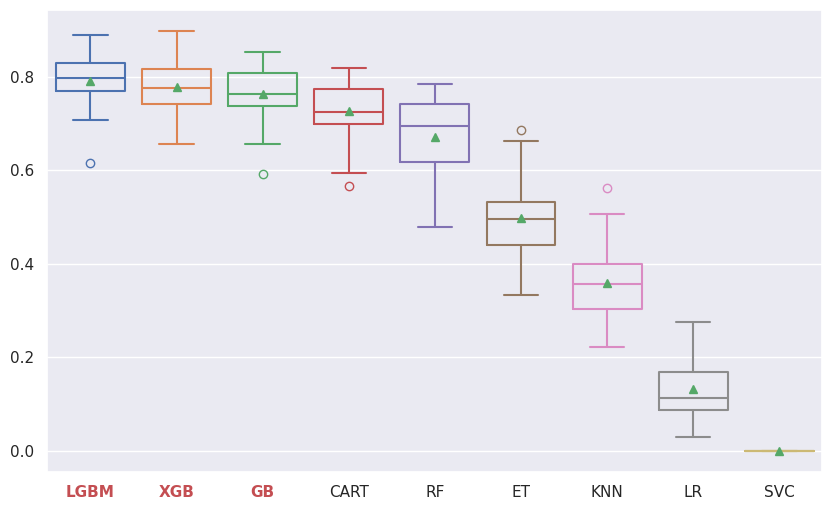

In [45]:
# visualizations
plot_kfold_results(
    names=names, results=results
)

# 2. Encoding

<b>Target & OneHot encoding</b>

In [52]:
# onehotencoding & targetencoding
## filter out warning
from warnings import simplefilter
simplefilter(action='ignore')

## encoding
ohe_idxes, te_idxes = [2, 3, 4], [0]
ohe = [('ohe', OneHotEncoder(drop='first', sparse_output=False), ohe_idxes)]
te = [('te', TargetEncoder(), te_idxes)]

## base models
models = load_base_models()

## pipelines
pipelines = get_pipelines(
    base_models=models, 
    ohe=ohe, other_encoders=te
)

## kfold results
names, results = get_kfold_results(
    models=pipelines,
    X=X_train, y=y_train
)

LR: 0.122258133034202 (0.05314324980784068)
KNN: 0.3590482148333225 (0.08163408925075537)
SVC: 0.011834319526627217 (0.014494022146646022)
CART: 0.727417074664632 (0.05870436591163995)
ET: 0.6030772947768999 (0.07634951455265143)
RF: 0.7532966082500591 (0.06150737703253661)
GB: 0.7630789805268205 (0.060332052267319164)
LGBM: 0.787906466286732 (0.057814076672830395)
XGB: 0.7809809716689321 (0.06386638505608619)


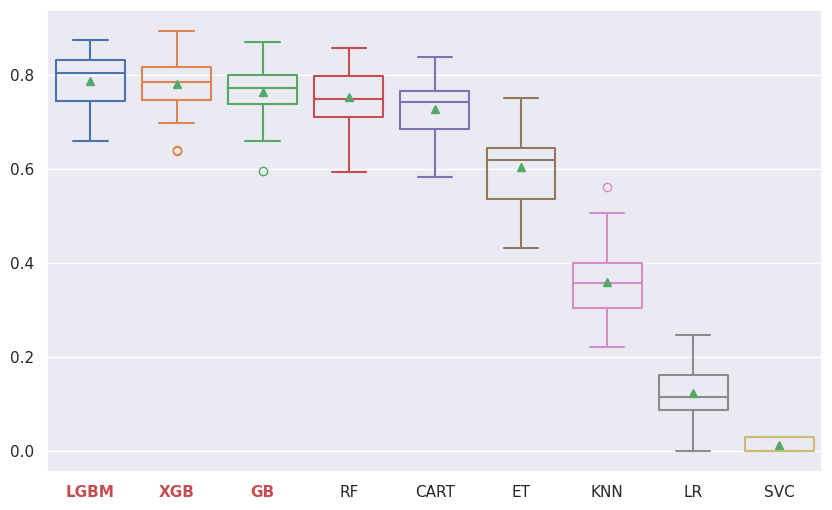

In [53]:
# visualization
plot_kfold_results(
    names=names, results=results
)

<b>Target encoding</b>

In [55]:
# targetencoding
## filter out warning
from warnings import simplefilter
simplefilter(action='ignore')

## encoding
te = [('te', TargetEncoder(), cat_idxes)]

## base models
models = load_base_models()

## pipelines
pipelines = get_pipelines(
    base_models=models, 
    ohe=ohe, other_encoders=te
)

## kfold results
names, results = get_kfold_results(
    models=pipelines,
    X=X_train, y=y_train
)

LR: 0.1252178813601241 (0.04793947364452391)
KNN: 0.3590482148333225 (0.08163408925075537)
SVC: 0.0059171597633136085 (0.011834319526627219)
CART: 0.718698246983062 (0.06267683139402927)
ET: 0.5342679480105288 (0.07533034418911974)
RF: 0.7569093931954355 (0.07217590263446652)
GB: 0.7674916721368236 (0.053712193806893106)
LGBM: 0.7915234245383511 (0.05517485330692093)
XGB: 0.7807181363988798 (0.05511148543858759)


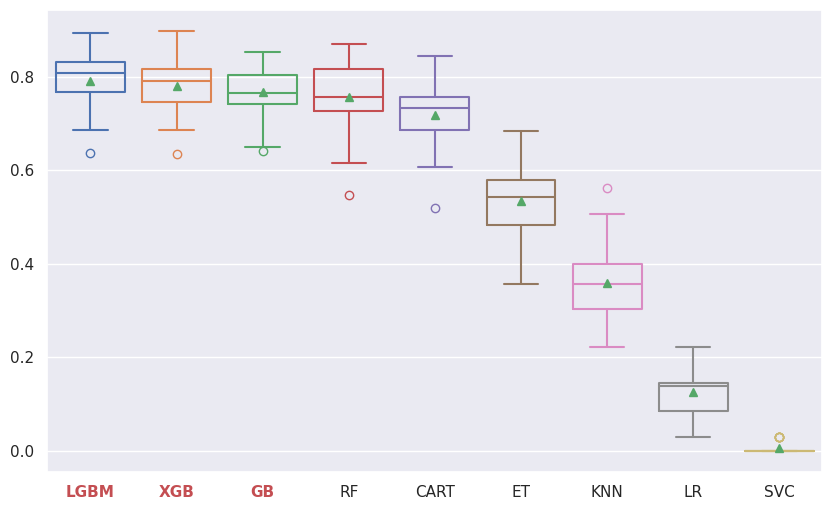

In [56]:
plot_kfold_results(
    names=names, results=results
)

<b>CatBoost && OneHot encoding</b>

In [55]:
## filter out warning
from warnings import simplefilter
simplefilter(action='ignore')

## encoding
cbe_idxes, ohe_idxes = [0], [2, 3, 4]
cbe = [('catboost', CatBoostEncoder(), cbe_idxes)]
ohe = [('ohe', OneHotEncoder(drop='first', sparse_output=False), ohe_idxes)]

## base models
models = load_base_models()

## pipelines
pipelines = get_pipelines(
    base_models=models, 
    ohe=ohe, other_encoders=cbe
)

## kfold results
names, results = get_kfold_results(
    models=pipelines, 
    X=X_train, y=y_train
)

LR: 0.12334399358015415 (0.04481620753855773)
KNN: 0.3590482148333225 (0.08163408925075537)
SVC: 0.011834319526627217 (0.014494022146646022)
CART: 0.7249827299800776 (0.06068264197261245)
ET: 0.5868283894350955 (0.07856826420290823)
RF: 0.7516580101039635 (0.06391959553879425)
GB: 0.768240768778311 (0.05885849822382924)
LGBM: 0.7869032156738132 (0.055376193248335696)
XGB: 0.7775885275459785 (0.06223643882091123)


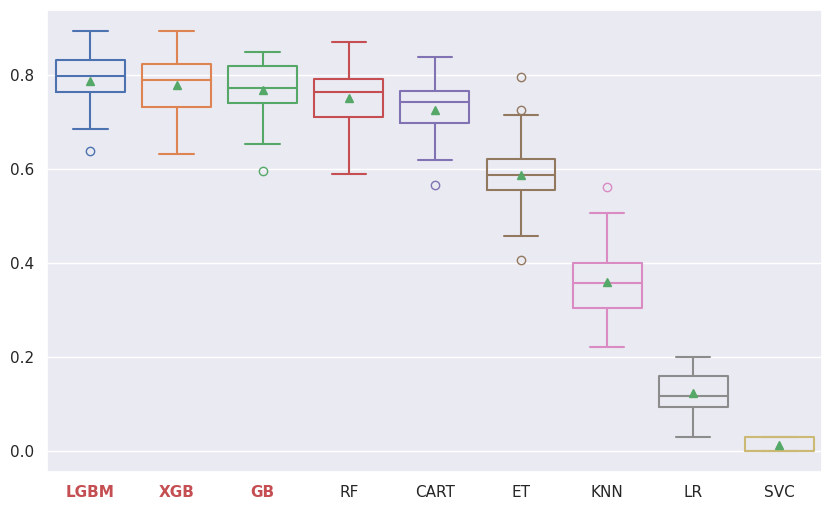

In [56]:
# visualization
plot_kfold_results(
    names=names, results=results
)

<b>CatBoost encoding</b>

In [57]:
## filter out warning
from warnings import simplefilter
simplefilter(action='ignore')

## encoding
cbe = [('catboost', CatBoostEncoder(), cat_idxes)]

## base models
models = load_base_models()

## pipelines
pipelines = get_pipelines(
    base_models=models, 
    ohe=ohe, other_encoders=cbe
)

## kfold results
names, results = get_kfold_results(
    models=pipelines, 
    X=X_train, y=y_train
)

LR: 0.12204600591987876 (0.04603904511538313)
KNN: 0.3590482148333225 (0.08163408925075537)
SVC: 0.0059171597633136085 (0.011834319526627219)
CART: 0.7275385743105574 (0.07194115590011195)
ET: 0.5674938831491635 (0.07581217381749919)
RF: 0.7470778044682462 (0.0738408756628239)
GB: 0.766425804540033 (0.05851130805368445)
LGBM: 0.7902404594650407 (0.06210488374707857)
XGB: 0.7751091320094037 (0.06127898770303105)


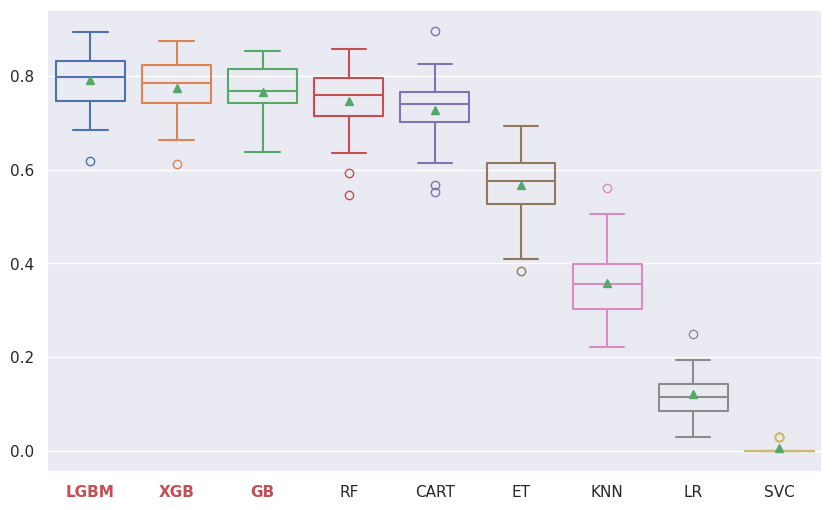

In [58]:
# visualization
plot_kfold_results(
    names=names, results=results
)

# 3. Scaling

<b>Standardization</b>

In [23]:
#
## filter out warnings
from warnings import simplefilter
simplefilter(action='ignore')

## base models
models = load_base_models()

## encoding
encoding = [('ohe', OneHotEncoder(drop='first', sparse_output=False), cat_idxes)]

## scaling
scaling = [('standardize', StandardScaler())]

## pipelines
pipelines = get_pipelines(
    base_models=models, 
    ohe=encoding, 
    scaling=scaling
)

## kfold results
names, results = get_kfold_results(
    models=pipelines, 
    X=X_train, y=y_train
)

LR: 0.2633537414257196 (0.06682514240928088)
KNN: 0.2997164925103952 (0.07652137167794573)
SVC: 0.4734928194957293 (0.08257488891987776)
CART: 0.7255786178088589 (0.055841621860836896)
ET: 0.4950644419239381 (0.0807974936864217)
RF: 0.6525110743299113 (0.07325585971477383)
GB: 0.7641028165973974 (0.057845416388528616)
LGBM: 0.7866142783049318 (0.05833958702772003)
XGB: 0.7802592983277485 (0.05482675914198851)


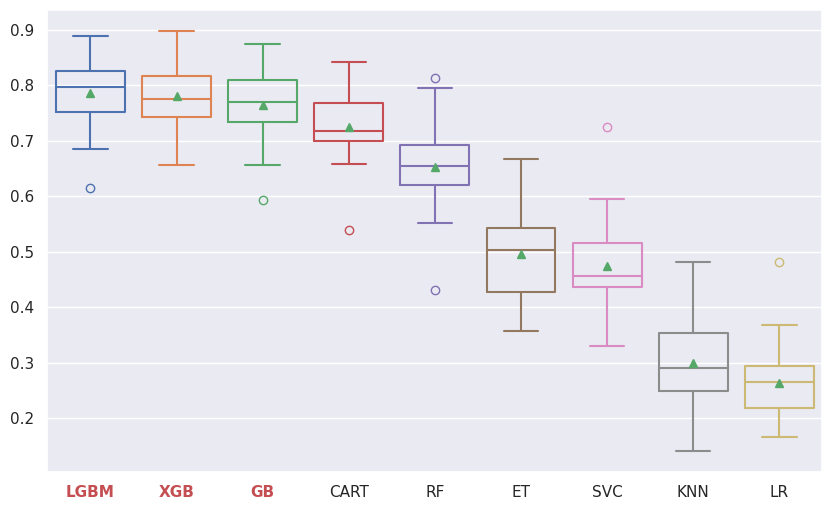

In [24]:
# visualization
plot_kfold_results(
    names=names, results=results
)

<b>Power transformation</b>

# 4.1 Feature Selection without "PCA"

<b>Sequential feature selection</b>

<b>RFE</b>

# 4.2 Feature Selection with "PCA"

<b>Sequential feature selection</b>

<b>RFE</b>

# 5. Resampling

<b>Over sampling</b>

<b>Combine</b>